# New Zealand Time-series Forecasting Model

# Pre-processing and Modeling 

In this notebook we are going to do pre-processing and modeling on our time-series data. We are going to decide what we want to focus on with this modeling. 

We'll start with the tourism arrivals data and then look at the accomodation data. 

We will beging by importing the necessary packages for looking at the data and creating our models.

[1.0 Tourism Data](#1.0-Tourism-Data)

[2.0 Accomodation Data](#2.0-Accomodation-Data)

In [1]:
# Import data processing packages
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error

#Time Series Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

#Time Series Modeling Packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from darts.models.forecasting import tbats
from darts import TimeSeries

#Modeling packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

#Visualization 
import matplotlib. pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", 'No frequency') 

# 1.0 Tourism Data
For our `arrivals` data we are going to look at the following regions as these have the most complete time-series data:
> - Auckland
> - Christchurch
> - Wellington
> - Queenstown
> - All New Zealand Ports
    
For each of these regions, we are going to look at the following reasons for travel:
> - Business
> - Holiday
> - Visiting Friends
> - Total Travel

We want to create the most complete picture that we can for our forecasting and making sure we work on creating as thorough of a forecasting as we can. 

In [3]:
## Load our Tourism Data
# Remove extra white space at end of column

arrivals = pd.read_csv('../NZ Data/Arrivals Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
arrivals.columns = arrivals.columns.str.replace(r' $','', regex = True)
arrivals.columns

Index(['BusinessAuckland', 'BusinessChristchurch', 'BusinessDunedin',
       'BusinessHamilton', 'BusinessPalmerston North', 'BusinessRotorua',
       'BusinessWellington', 'BusinessQueenstown',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland',
       'Holiday/VacationChristchurch', 'Holiday/VacationDunedin',
       'Holiday/VacationHamilton', 'Holiday/VacationPalmerston North',
       'Holiday/VacationRotorua', 'Holiday/VacationWellington',
       'Holiday/VacationQueenstown', 'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland',
       'Visit Friends/RelativesChristchurch', 'Visit Friends/RelativesDunedin',
       'Visit Friends/RelativesHamilton',
       'Visit Friends/RelativesPalmerston North',
       'Visit Friends/RelativesRotorua', 'Visit Friends/RelativesWellington',
       'Visit Friends/RelativesQueenstown',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPOSESAuckland',
       'TOTAL ALL

In [4]:
# Check to make sure index is datetime
arrivals.index

DatetimeIndex(['1978-04-01', '1978-05-01', '1978-06-01', '1978-07-01',
               '1978-08-01', '1978-09-01', '1978-10-01', '1978-11-01',
               '1978-12-01', '1979-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [5]:
arrivals.head()

,BusinessAuckland,BusinessChristchurch,BusinessDunedin,BusinessHamilton,BusinessPalmerston North,BusinessRotorua,BusinessWellington,BusinessQueenstown,BusinessTOTAL NEW ZEALAND PORTS,Holiday/VacationAuckland,...,Visit Friends/RelativesTOTAL NEW ZEALAND PORTS,TOTAL ALL TRAVEL PURPOSESAuckland,TOTAL ALL TRAVEL PURPOSESChristchurch,TOTAL ALL TRAVEL PURPOSESDunedin,TOTAL ALL TRAVEL PURPOSESHamilton,TOTAL ALL TRAVEL PURPOSESPalmerston North,TOTAL ALL TRAVEL PURPOSESRotorua,TOTAL ALL TRAVEL PURPOSESWellington,TOTAL ALL TRAVEL PURPOSESQueenstown,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
Date,,,,,,,,,,,,,,,,,,,,,
1978-04-01,3428.0,468.0,0.0,0.0,0.0,0.0,492.0,0.0,4408.0,10476.0,...,3324.0,19856.0,6240.0,0.0,0.0,0.0,0.0,2116.0,0.0,28524.0
1978-05-01,2264.0,524.0,0.0,0.0,0.0,0.0,428.0,0.0,3236.0,7168.0,...,3568.0,15428.0,5240.0,0.0,0.0,0.0,0.0,2156.0,0.0,23060.0
1978-06-01,2136.0,280.0,0.0,0.0,0.0,0.0,384.0,0.0,2880.0,4640.0,...,2600.0,11416.0,2708.0,0.0,0.0,0.0,0.0,1252.0,0.0,15760.0
1978-07-01,2156.0,324.0,0.0,0.0,0.0,0.0,380.0,0.0,2964.0,6184.0,...,3144.0,14072.0,4900.0,0.0,0.0,0.0,0.0,1480.0,0.0,20892.0
1978-08-01,2304.0,536.0,0.0,0.0,0.0,0.0,496.0,0.0,3416.0,8236.0,...,4204.0,17960.0,7900.0,0.0,0.0,0.0,0.0,2748.0,0.0,28992.0


In [6]:
# Load our model results from the pycaret notebook to look at which models might work best for us
potential_models = pd.read_csv('../NZ Data/arrivals_model_results.csv',index_col = 0)
potential_models.head()

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec),time_series
exp_smooth,Exponential Smoothing,1847.5938,3040.2741,8.729000e+00,0.1226,2.1202,2.6894,0.5610,0.0433,BusinessAuckland
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,292.8787,448.0243,1.619677e+17,0.1555,1.2487,1.4706,0.4044,0.0133,BusinessChristchurch
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,23.9385,29.7550,2.358377e+16,0.5721,1.2396,0.8072,-0.4410,0.0300,BusinessDunedin
naive,Naive Forecaster,0.5139,2.4227,5.560000e-02,0.1111,0.0278,0.0721,-0.0580,0.0067,BusinessHamilton
naive,Naive Forecaster,0.0000,0.0000,0.000000e+00,0.0000,0.0000,0.0000,1.0000,0.0033,BusinessPalmerston North


We have here the list of all of our models that we tested using the pycaret model. As discussed in our previous notebook, we are not interested in actually modeling out all of these trends due to issues with the data or lack of historic data. We'll start with looking at our Arrivals dataset.

We will be forecasting the following datasets from the Arrivals dataset:
- TOTAL ALL TRAVEL PURPOSESAuckland
- TOTAL ALL TRAVEL PURPOSESChristchurch
- TOTAL ALL TRAVEL PURPOSESWellington
- TOTAL ALL TRAVEL PURPOSESQueenstown
- TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
- BusinessAuckland
- BusinessChristchurch
- BusinessWellington
- BusinessQueenstown
- BusinessTOTAL NEW ZEALAND PORTS
- Holiday/VacationAuckland
- Holiday/VacationChristchurch
- Holiday/VacationWellington
- Holiday/VacationQueenstown
- Holiday/VacationTOTAL NEW ZEALAND PORTS

This is capture a wide breadth of models without overwhelming ourselves. Thus to make our above model results table more readable, we will subset and look at only the subset we are interested in.

In [7]:
# Creating list of subset
arrivals_model_list = ['TOTAL ALL TRAVEL PURPOSESAuckland', 'TOTAL ALL TRAVEL PURPOSESChristchurch', \
                       'TOTAL ALL TRAVEL PURPOSESWellington', 'TOTAL ALL TRAVEL PURPOSESQueenstown',\
                      'TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS',\
                      'BusinessAuckland','BusinessChristchurch','BusinessWellington', 'BusinessQueenstown',\
                      'BusinessTOTAL NEW ZEALAND PORTS',\
                      'Holiday/VacationAuckland','Holiday/VacationChristchurch', 'Holiday/VacationWellington',\
                      'Holiday/VacationQueenstown','Holiday/VacationTOTAL NEW ZEALAND PORTS']

In [8]:
arrivals_model_sub = potential_models[potential_models['time_series'].isin(arrivals_model_list)]
arrivals_model_sub

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec),time_series
exp_smooth,Exponential Smoothing,1847.5938,3040.2741,8.729000e+00,0.1226,2.1202,2.6894,0.5610,0.0433,BusinessAuckland
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,292.8787,448.0243,1.619677e+17,0.1555,1.2487,1.4706,0.4044,0.0133,BusinessChristchurch
exp_smooth,Exponential Smoothing,327.0615,524.7345,1.770958e+17,0.1482,1.4467,1.7891,0.4479,0.0367,BusinessWellington
ets,ETS,119.2602,168.2450,8.942974e+16,0.2367,3.7151,2.4567,0.2016,0.0233,BusinessQueenstown
exp_smooth,Exponential Smoothing,2358.3273,3905.6734,9.939400e+00,0.1205,2.1454,2.6784,0.5673,0.0367,BusinessTOTAL NEW ZEALAND PORTS
exp_smooth,Exponential Smoothing,12117.3473,19304.4273,5.368140e+02,0.1544,2.8171,3.0665,0.7523,0.0400,Holiday/VacationAuckland
arima,ARIMA,3625.2503,5694.6243,1.042121e+18,0.1666,1.7507,1.9920,0.7231,0.0267,Holiday/VacationChristchurch
ets,ETS,675.4676,984.8151,4.986480e+17,0.1872,1.7478,1.4984,0.6799,0.0300,Holiday/VacationWellington
ets,ETS,1807.8334,2922.2105,2.023709e+18,0.1426,4.3983,3.0722,0.8024,0.0300,Holiday/VacationQueenstown
bats,BATS,17376.7744,27582.7610,5.915086e+02,0.1480,2.8512,3.1626,0.7463,7.4733,Holiday/VacationTOTAL NEW ZEALAND PORTS


## Modeling Business Time Series

In this section we will model out our business model time series and analyze those results

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

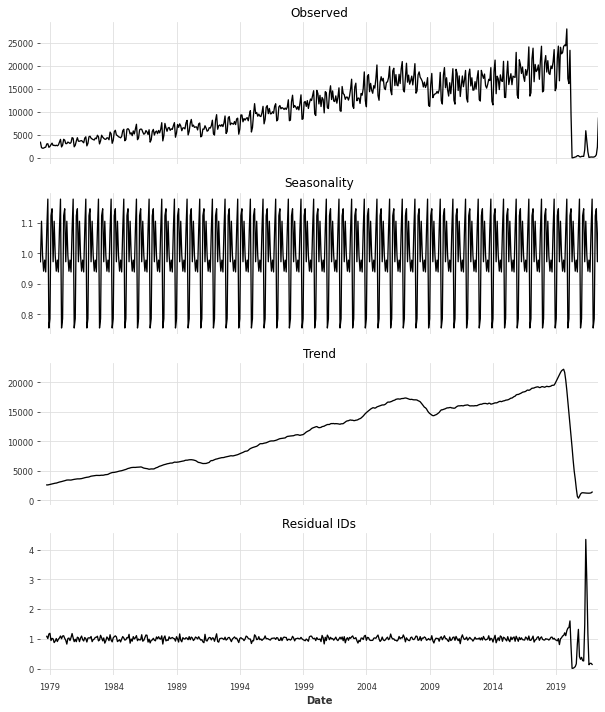

In [9]:
# Start with BusinessAuckland, we will use ExponentialSmoothing to model 
# First lets look at the data and understand its seasonality and ACF/PACF

y = arrivals['BusinessAuckland']

res = seasonal_decompose(y, model='mult')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [10]:
# Since we have opted to use exponential smoothing, we are not required to take the first difference
# Exponential smoothing can handle trend data 
# The statsmodel implementation of Exponentail Smoothing also optimizes its hyperparamters

exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)

In [11]:
exp_fit = exp.fit(method = 'bh')
exp_fit.summary()

Dep. Variable:,BusinessAuckland,No. Observations:,530
Model:,ExponentialSmoothing,SSE,856887330.032
Optimized:,True,AIC,7610.848
Trend:,Multiplicative,BIC,7683.487
Seasonal:,Multiplicative,AICC,7612.338
Seasonal Periods:,12,Date:,"Thu, 28 Jul 2022"
Box-Cox:,False,Time:,00:27:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8037184,alpha,True
smoothing_trend,0.000000,beta,True


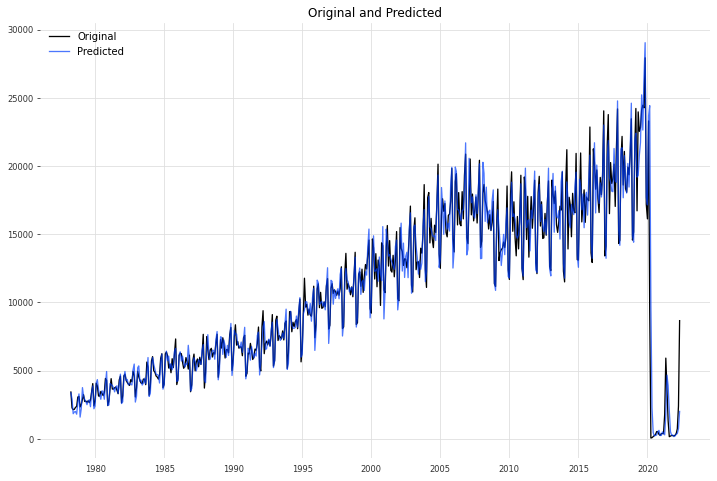

In [12]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [13]:
y_fore = exp_fit.forecast(36)

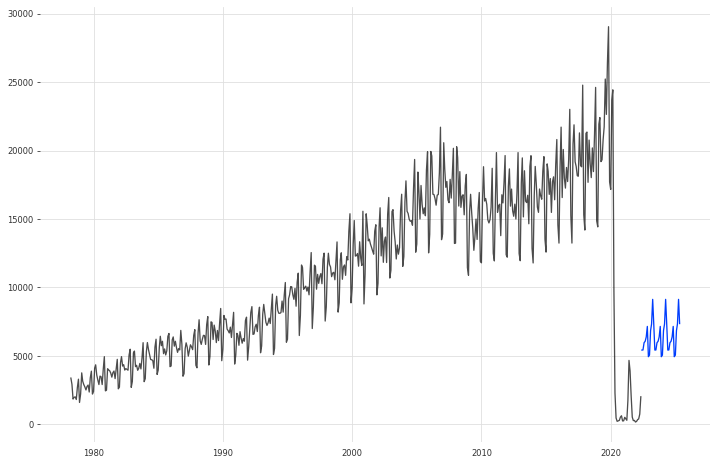

In [14]:
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

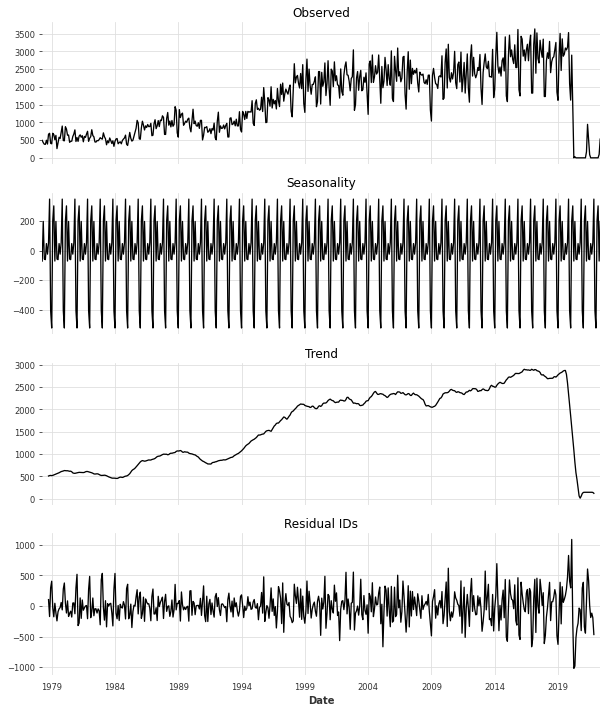

In [15]:
# Business Wellington
y = arrivals['BusinessWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

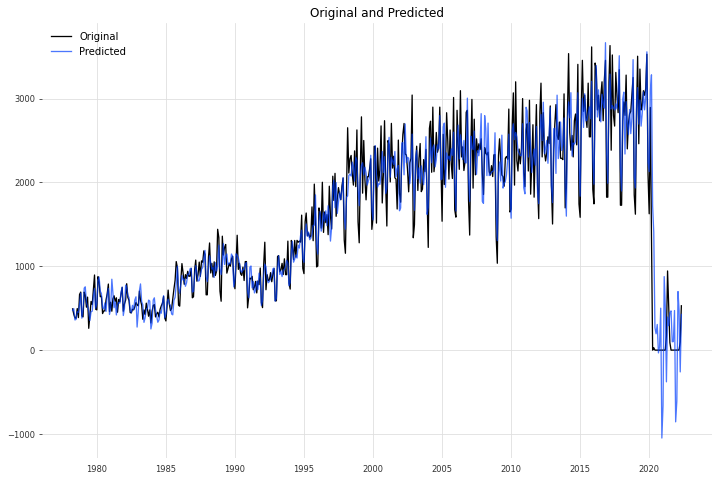

In [16]:
exp = ExponentialSmoothing(y, trend = 'add', seasonal = 'add', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'bh')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [17]:
exp_fit.summary()

Dep. Variable:,BusinessWellington,No. Observations:,530
Model:,ExponentialSmoothing,SSE,43476340.087
Optimized:,True,AIC,6030.871
Trend:,Additive,BIC,6103.510
Seasonal:,Additive,AICC,6032.361
Seasonal Periods:,12,Date:,"Thu, 28 Jul 2022"
Box-Cox:,False,Time:,00:27:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4589010,alpha,True
smoothing_trend,0.000000,beta,True


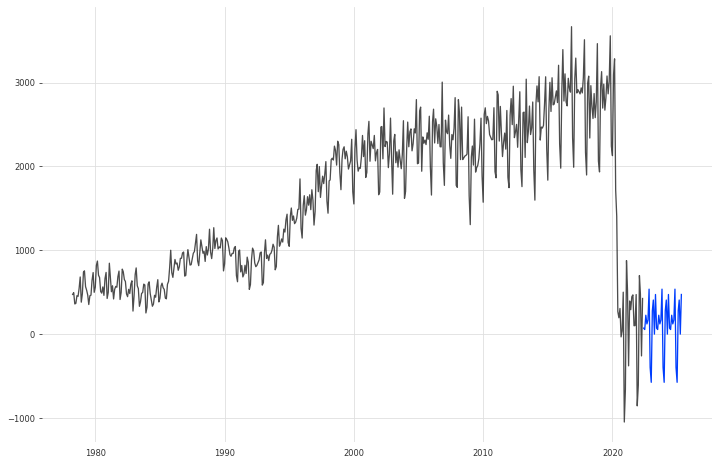

In [18]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

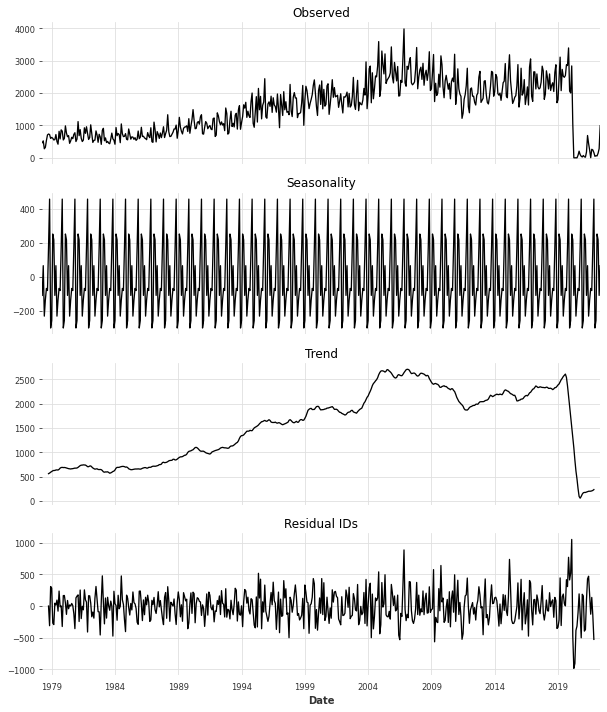

In [19]:
# BUSINESS CHRISTCHURCH
# Pycaret helped us decide that a linear model with deseasonilization and detrending would be the best model to utilize

y = arrivals['BusinessChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [20]:
dftest = adfuller(y, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5760617670588788
2. P-Value :  0.49560631382433273
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 512
5. Critical Values :
	 1% :  -3.443186695642769
	 5% :  -2.86720156693697
	 10% :  -2.569785402984619


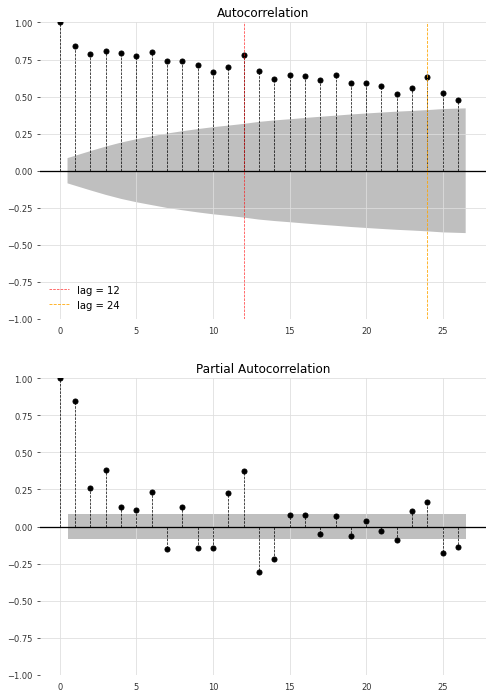

In [21]:
# Due to the linearity of this data, we shall use SARIMAX as it is the combination of Linear Regression and SARIMA 
# Lets first look at the ACF and PACF 

fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [22]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  530
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -3743.933
Date:                            Thu, 28 Jul 2022   AIC                           7495.866
Time:                                    00:29:07   BIC                           7512.950
Sample:                                         0   HQIC                          7502.553
                                            - 530                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5480      0.019    -28.893      0.000      -0.585      -0.511
ar.S.L12       0.9741      0.013     73.777      0.000       0.948       1.000
ma.S.L12      -0.7840      0.038    -20.502      0.000      -0.859      -0.709
sigma2      8.024e+04   3055.030     26.263      0.000    7.42e+04    8.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               595.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.36   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model = sarimax.SARIMAX(y, order=(0,1,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:               BusinessChristchurch   No. Observations:                  530
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -3743.933
Date:                            Thu, 28 Jul 2022   AIC                           7495.866
Time:                                    00:29:08   BIC                           7512.950
Sample:                                04-01-1978   HQIC                          7502.553
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5480      0.019    -28.893      0.000      -0.585      -0.511
ar.S.L12       0.9741      0.013     73.777      0.000       0.948       1.000
ma.S.L12      -0.7840      0.038    -20.502      0.000      -0.859      -0.709
sigma2      8.024e+04   3055.030     26.263      0.000    7.42e+04    8.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               595.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.36   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

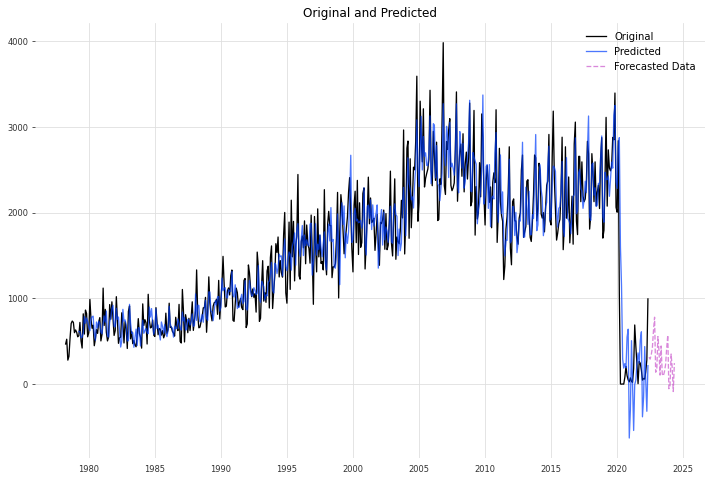

In [24]:

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

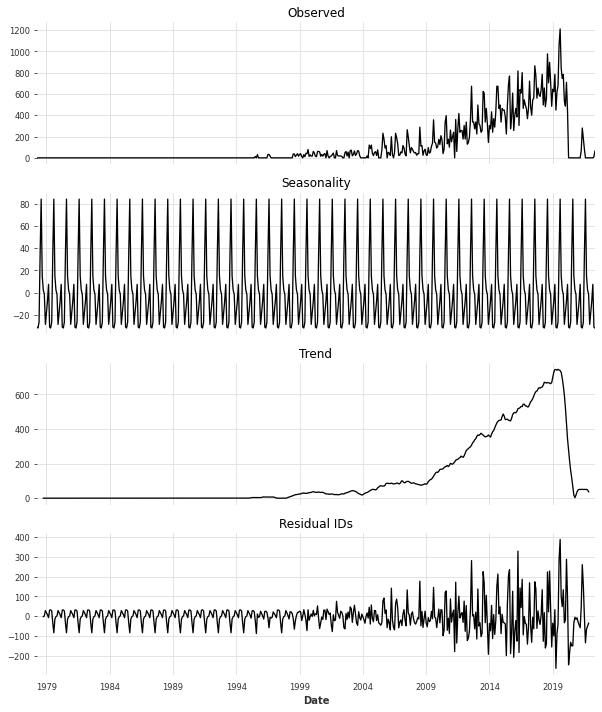

In [25]:
# Business Queenstown using ETS
y = arrivals['BusinessQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

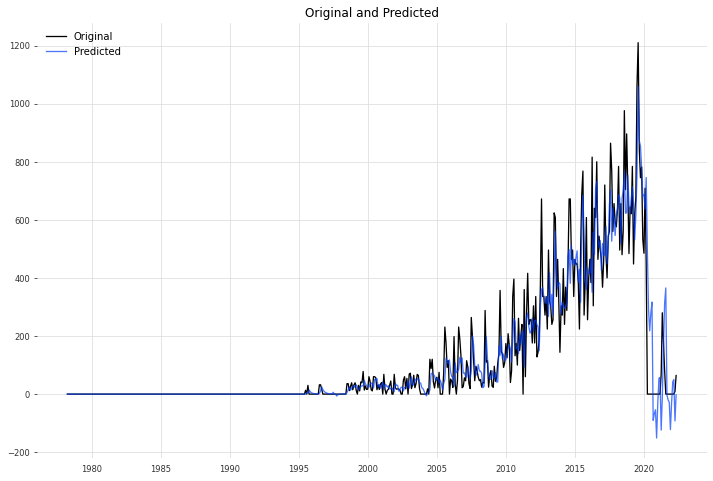

In [26]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [27]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:     BusinessQueenstown   No. Observations:                  530
Model:                      ETS(AAdA)   Log Likelihood               -3085.020
Date:                Thu, 28 Jul 2022   AIC                           6208.039
Time:                        00:29:09   BIC                           6289.224
Sample:                    04-01-1978   HQIC                          6239.816
                         - 05-01-2022   Scale                         6658.878
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4135      0.034     12.211      0.000       0.347       0.480
smoothing_trend      4.135e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.1438      0.025      5.741      0.000       0.095       0.193
damping_trend           0.8000        nan        nan        nan         nan         nan
initial_level       -2.772e-06     80.375  -3.45e-08      1.000    -157.532     157.532
initial_trend        1.153e-05     40.804   2.83e-07      1.000     -79.974      79.974
initial_seasonal.0   6.306e-05     36.608   1.72e-06      1.000     -71.751      71.751
initial_seasonal.1   1.924e-05     36.545   5.26e-07      1.000     -71.627      71.627
initial_seasonal.2  -2.178e-05     36.530  -5.96e-07      1.000     -71.598      71.598
initial_seasonal.3  -7.239e-05     36.607  -1.98e-06      1.000     -71.749      71.749
initial_seasonal.4  -1.286e-05     36.702   -3.5e-07      1.000     -71.934      71.934
initial_seasonal.5  -2.452e-05     36.746  -6.67e-07      1.000     -72.020      72.020
initial_seasonal.6  -1.685e-06     36.537  -4.61e-08      1.000     -71.611      71.611
initial_seasonal.7      0.0002     36.230    5.7e-06      1.000     -71.009      71.009
initial_seasonal.8   7.497e-05     36.245   2.07e-06      1.000     -71.039      71.039
initial_seasonal.9  -9.028e-05     36.237  -2.49e-06      1.000     -71.024      71.024
initial_seasonal.10 -7.609e-05     36.170   -2.1e-06      1.000     -70.892      70.892
initial_seasonal.11          0     36.051          0      1.000     -70.658      70.658
===================================================================================
Ljung-Box (Q):                       49.64   Jarque-Bera (JB):              1508.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):          149928.29   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+17. Standard errors may be unstable.
"""

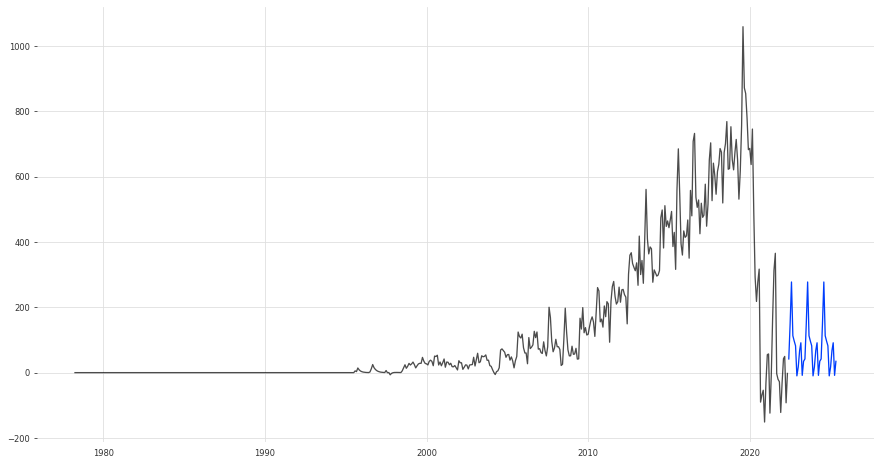

In [28]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

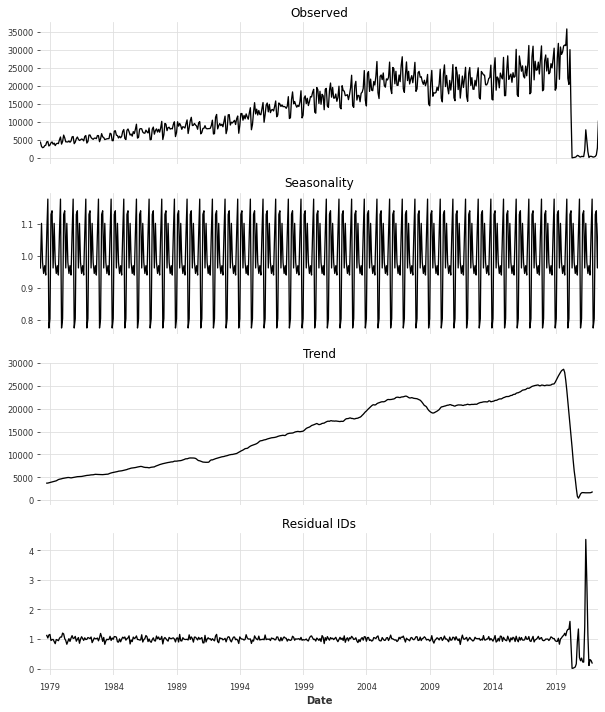

In [29]:
#All BUsiness NZ
y = arrivals['BusinessTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

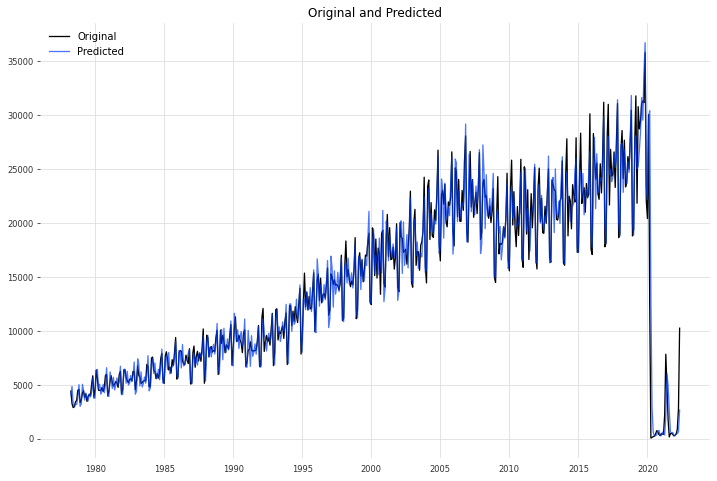

In [30]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [31]:
exp_fit.summary()

Dep. Variable:,BusinessTOTAL NEW ZEALAND PORTS,No. Observations:,530
Model:,ExponentialSmoothing,SSE,1339205741.743
Optimized:,True,AIC,7847.507
Trend:,Multiplicative,BIC,7920.146
Seasonal:,Multiplicative,AICC,7848.997
Seasonal Periods:,12,Date:,"Thu, 28 Jul 2022"
Box-Cox:,False,Time:,00:29:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000939,alpha,True
smoothing_trend,1.6292e-33,beta,True


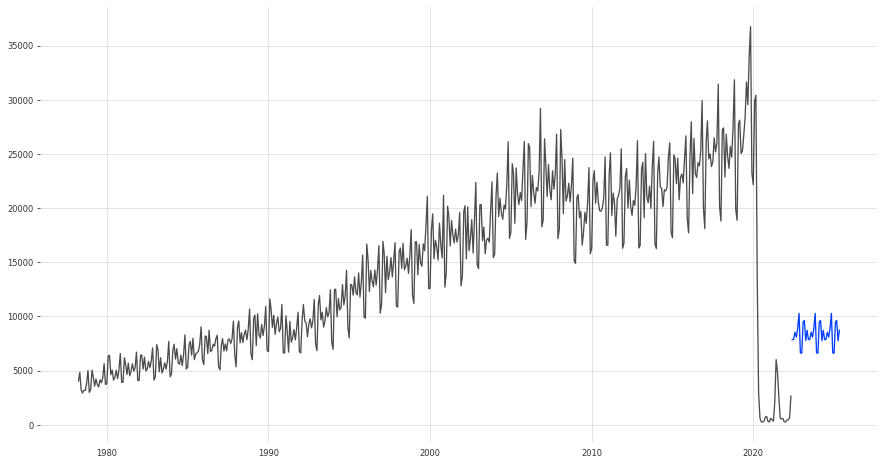

In [32]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

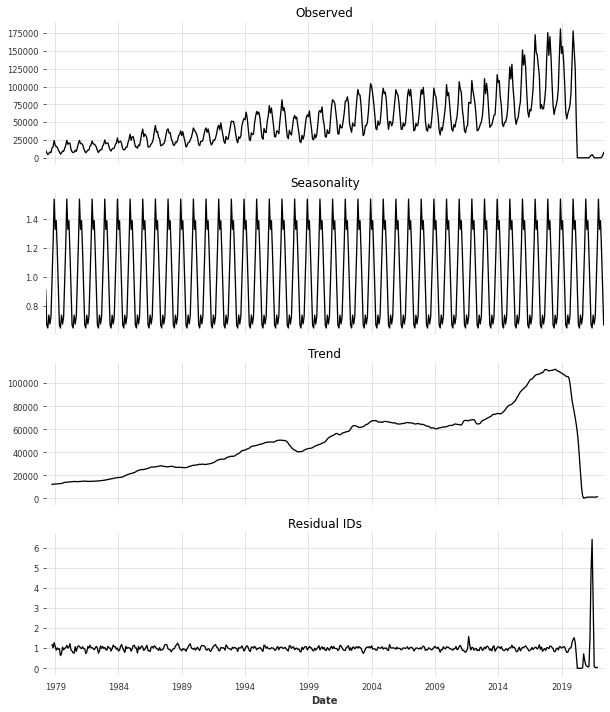

In [33]:
#Holiday/VacationAuckland Exp Smoothing
y = arrivals['Holiday/VacationAuckland']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

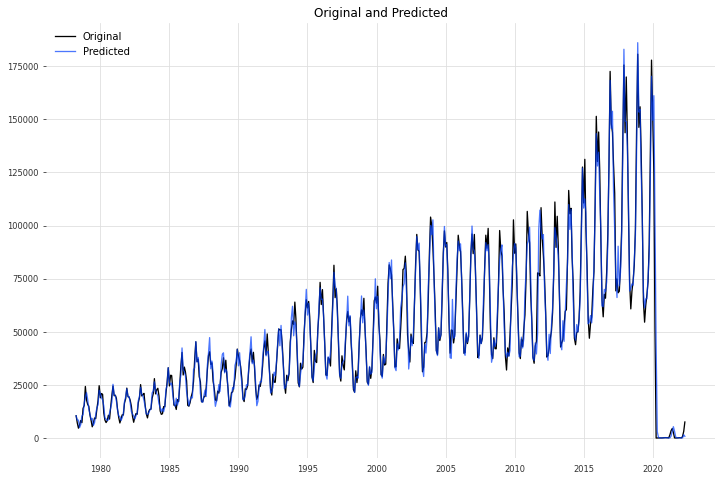

In [34]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [35]:
exp_fit.summary()

Dep. Variable:,Holiday/VacationAuckland,No. Observations:,530
Model:,ExponentialSmoothing,SSE,18702721394.820
Optimized:,True,AIC,9244.901
Trend:,Multiplicative,BIC,9317.540
Seasonal:,Multiplicative,AICC,9246.391
Seasonal Periods:,12,Date:,"Thu, 28 Jul 2022"
Box-Cox:,False,Time:,00:29:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8937923,alpha,True
smoothing_trend,3.2978e-21,beta,True


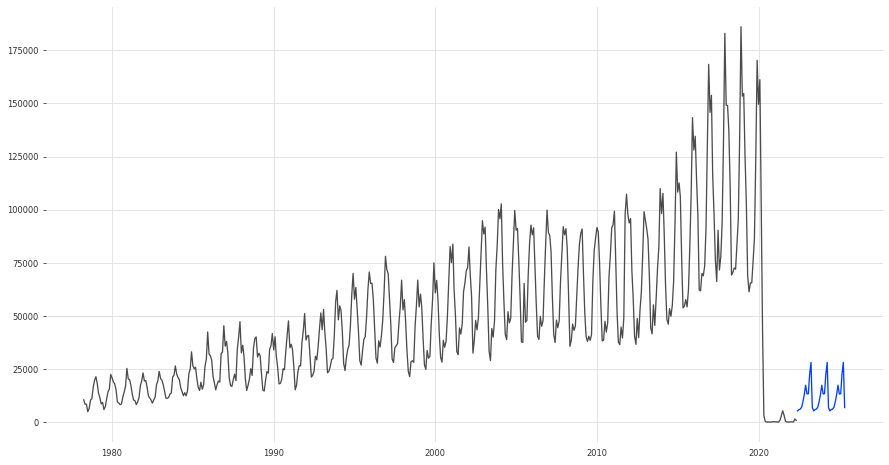

In [36]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

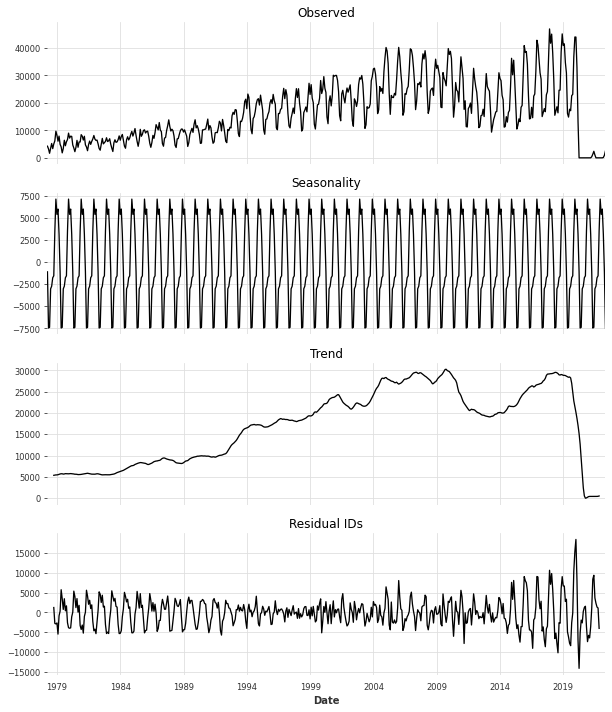

In [37]:
#Holiday/VacationChristchurch ARIMA
y = arrivals['Holiday/VacationChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

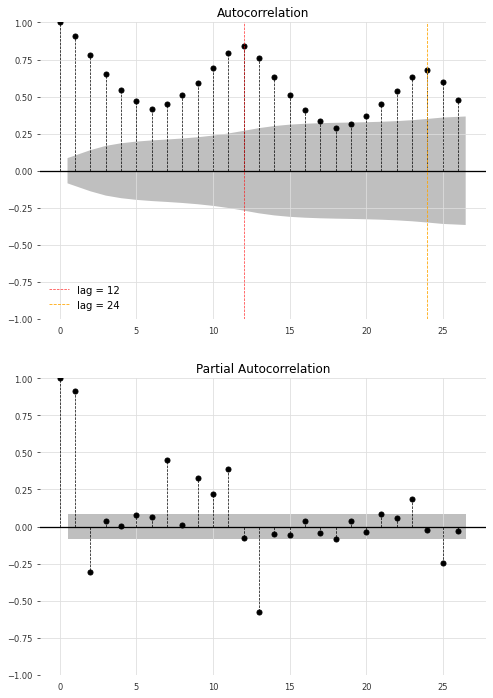

In [38]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [39]:
dftest = adfuller(y, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.630032621292153
2. P-Value :  0.46747363801463915
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 517
5. Critical Values :
	 1% :  -3.443061925077973
	 5% :  -2.8671466525252014
	 10% :  -2.5697561378507907


In [40]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  530
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -4895.556
Date:                                 Thu, 28 Jul 2022   AIC                           9805.112
Time:                                         00:30:40   BIC                           9835.009
Sample:                                              0   HQIC                          9816.815
                                                 - 530                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9126      0.030     30.702      0.000       0.854       0.971
ar.L2         -0.0982      0.029     -3.356      0.001      -0.156      -0.041
ma.L1         -0.9428      0.024    -39.617      0.000      -0.989      -0.896
ar.S.L12       0.9587      0.015     65.241      0.000       0.930       0.988
ma.S.L12      -0.5216      0.038    -13.787      0.000      -0.596      -0.447
ma.S.L24      -0.1127      0.044     -2.564      0.010      -0.199      -0.027
sigma2      6.384e+06   2.51e-09   2.54e+15      0.000    6.38e+06    6.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               651.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               9.31   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.85e+30. Standard errors may be unstable.
"""

In [41]:
model = sarimax.SARIMAX(y, order=(0,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         Holiday/VacationChristchurch   No. Observations:                  530
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -4909.268
Date:                              Thu, 28 Jul 2022   AIC                           9826.536
Time:                                      00:30:41   BIC                           9843.620
Sample:                                  04-01-1978   HQIC                          9833.224
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.1269      0.087     12.934      0.000       0.956       1.298
ar.S.L24      -0.1596      0.073     -2.176      0.030      -0.303      -0.016
ma.S.L12      -0.6948      0.086     -8.078      0.000      -0.863      -0.526
sigma2      6.764e+06   3.03e-09   2.23e+15      0.000    6.76e+06    6.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               550.66
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+30. Standard errors may be unstable.
"""

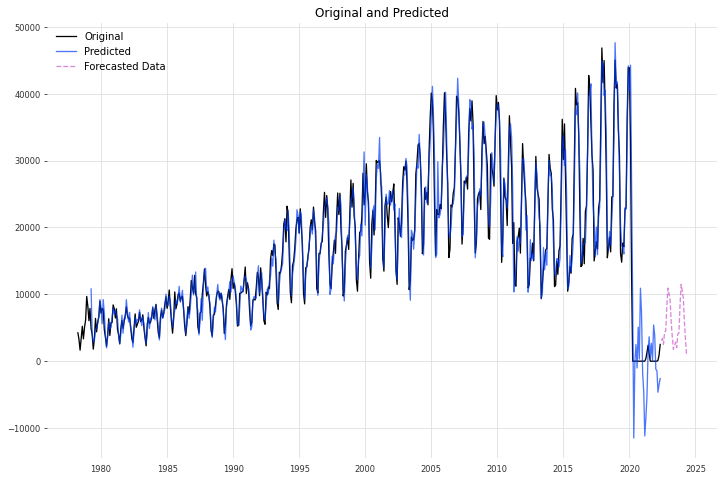

In [42]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

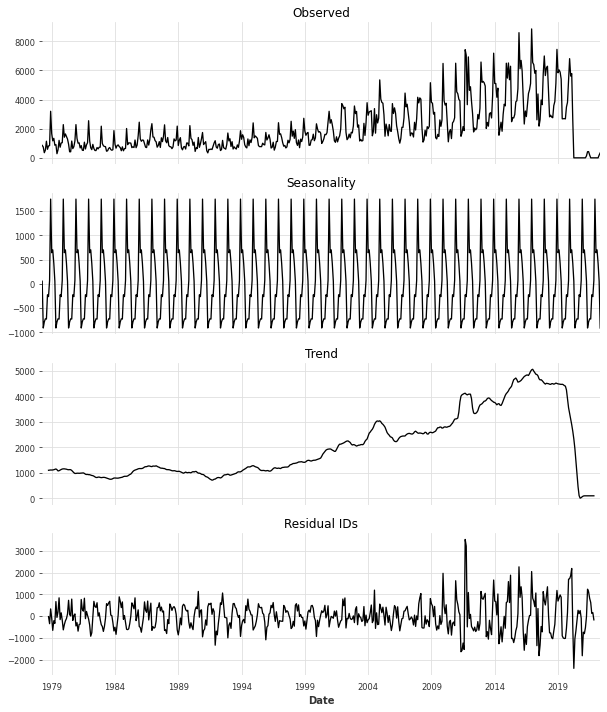

In [43]:
#Holiday/VacationWellington ETS
y = arrivals['Holiday/VacationWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

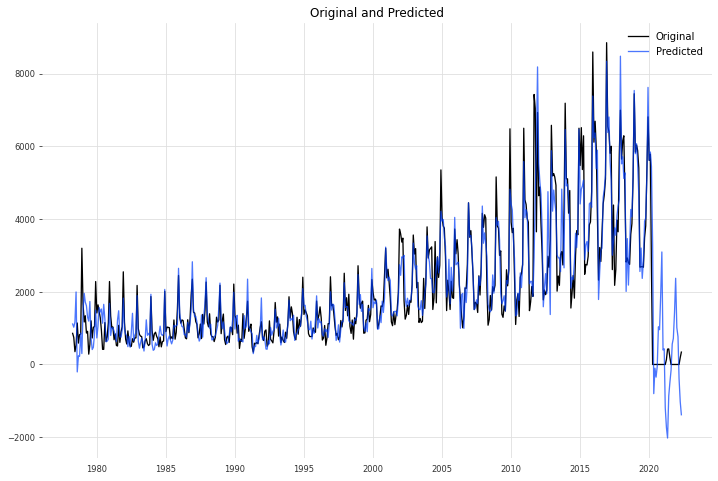

In [44]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [45]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationWellington   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4182.931
Date:                        Thu, 28 Jul 2022   AIC                           8403.862
Time:                                00:30:42   BIC                           8485.047
Sample:                            04-01-1978   HQIC                          8435.639
                                 - 05-01-2022   Scale                       419478.935
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4368      0.080      5.443      0.000       0.280       0.594
smoothing_trend      4.368e-05      0.006      0.007      0.994      -0.012       0.012
smoothing_seasonal      0.3788      0.060      6.319      0.000       0.261       0.496
damping_trend           0.8285        nan        nan        nan         nan         nan
initial_level        1112.4555    577.007      1.928      0.054     -18.458    2243.369
initial_trend           1.0599    286.432      0.004      0.997    -560.337     562.457
initial_seasonal.0   -159.2915    424.081     -0.376      0.707    -990.474     671.891
initial_seasonal.1   -262.9998    421.741     -0.624      0.533   -1089.598     563.598
initial_seasonal.2   -652.5100    446.834     -1.460      0.144   -1528.289     223.269
initial_seasonal.3   -572.7699    554.582     -1.033      0.302   -1659.731     514.191
initial_seasonal.4    -22.1460    423.162     -0.052      0.958    -851.528     807.236
initial_seasonal.5   -401.7708    422.010     -0.952      0.341   -1228.895     425.353
initial_seasonal.6   -231.6251    420.174     -0.551      0.581   -1055.152     591.902
initial_seasonal.7    -89.2500    423.383     -0.211      0.833    -919.066     740.566
initial_seasonal.8   1469.4990    571.892      2.570      0.010     348.611    2590.387
initial_seasonal.9    286.9579    442.143      0.649      0.516    -579.626    1153.541
initial_seasonal.10    23.7499    417.542      0.057      0.955    -794.617     842.116
initial_seasonal.11          0    420.273          0      1.000    -823.719     823.719
===================================================================================
Ljung-Box (Q):                      157.56   Jarque-Bera (JB):              1616.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.72   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+16. Standard errors may be unstable.
"""

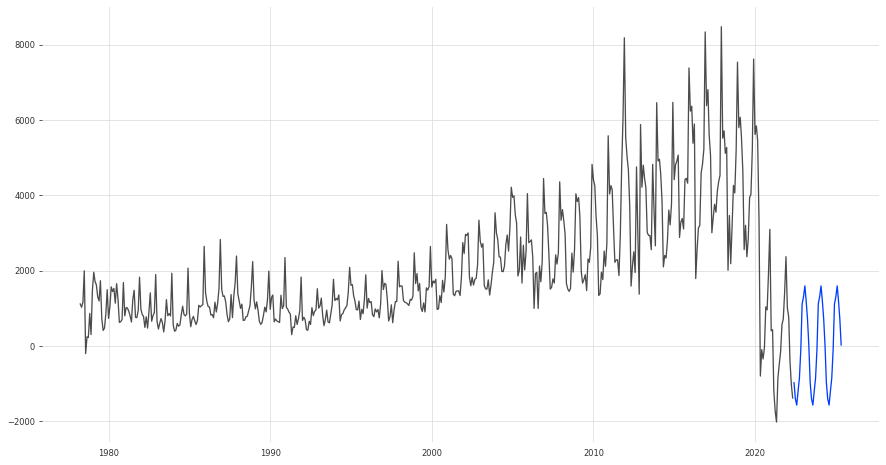

In [46]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

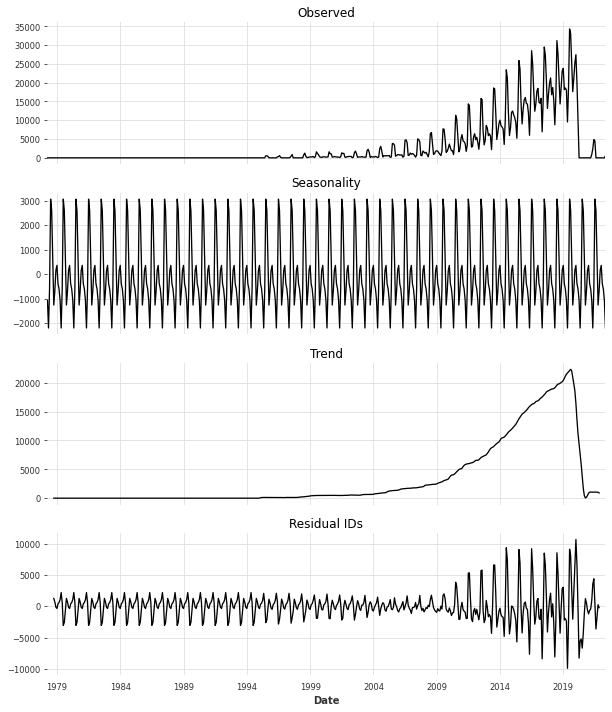

In [47]:
#Holiday/VacationQueenstown ETS
y = arrivals['Holiday/VacationQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

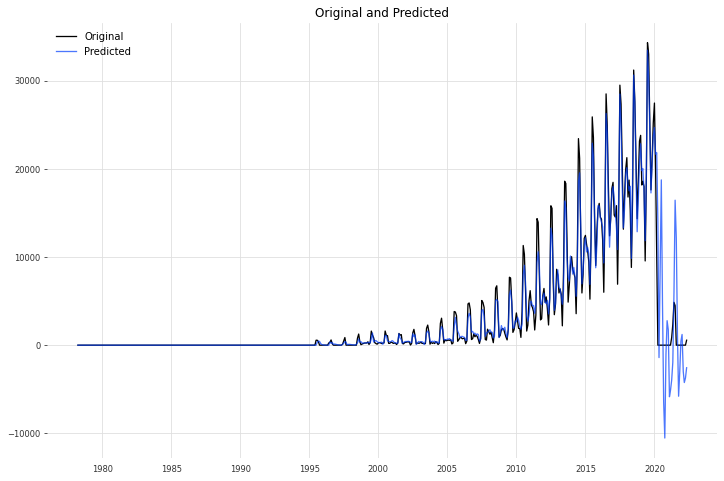

In [48]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [49]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationQueenstown   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4740.268
Date:                        Thu, 28 Jul 2022   AIC                           9518.535
Time:                                00:30:43   BIC                           9599.720
Sample:                            04-01-1978   HQIC                          9550.312
                                 - 05-01-2022   Scale                      3436365.816
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5929      0.044     13.409      0.000       0.506       0.680
smoothing_trend      5.929e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.4071      0.039     10.545      0.000       0.331       0.483
damping_trend           0.8664        nan        nan        nan         nan         nan
initial_level        1.621e-07   1603.814   1.01e-10      1.000   -3143.418    3143.418
initial_trend        5.418e-08    813.070   6.66e-11      1.000   -1593.587    1593.587
initial_seasonal.0  -2.194e-06   1157.737   -1.9e-09      1.000   -2269.122    2269.122
initial_seasonal.1   -1.27e-06   1155.045   -1.1e-09      1.000   -2263.847    2263.847
initial_seasonal.2     1.6e-06   1152.562   1.39e-09      1.000   -2258.980    2258.980
initial_seasonal.3   7.747e-07   1150.130   6.74e-10      1.000   -2254.212    2254.212
initial_seasonal.4  -2.707e-06   1147.446  -2.36e-09      1.000   -2248.954    2248.954
initial_seasonal.5  -5.419e-06   1144.431  -4.73e-09      1.000   -2243.044    2243.044
initial_seasonal.6   2.061e-06   1141.440   1.81e-09      1.000   -2237.182    2237.182
initial_seasonal.7   9.799e-06   1139.147    8.6e-09      1.000   -2232.688    2232.688
initial_seasonal.8   1.199e-05   1138.222   1.05e-08      1.000   -2230.874    2230.874
initial_seasonal.9  -2.436e-06   1139.161  -2.14e-09      1.000   -2232.715    2232.715
initial_seasonal.10 -8.388e-06   1142.464  -7.34e-09      1.000   -2239.188    2239.188
initial_seasonal.11          0   1148.984          0      1.000   -2251.967    2251.967
===================================================================================
Ljung-Box (Q):                      375.54   Jarque-Bera (JB):             31912.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           24305.61   Skew:                            -3.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+17. Standard errors may be unstable.
"""

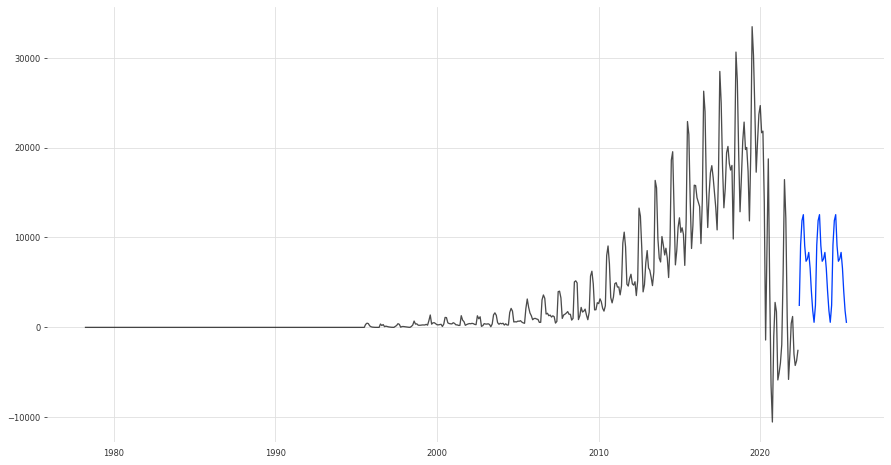

In [50]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

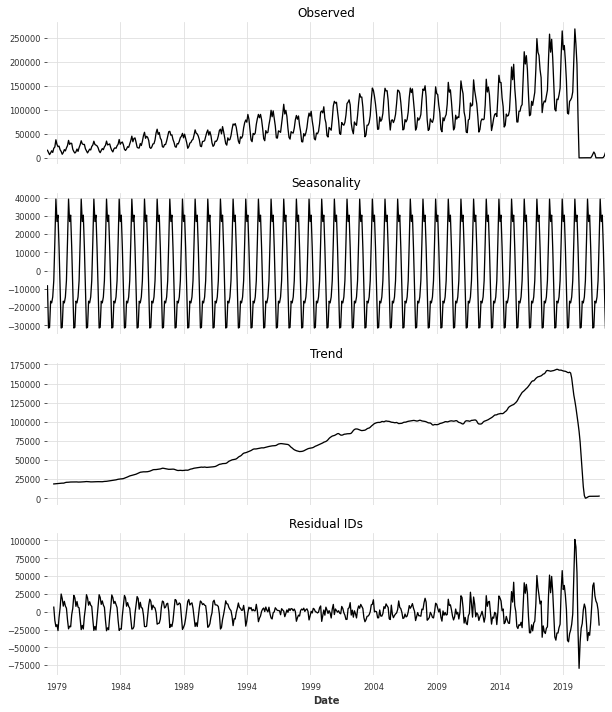

In [51]:

#Holiday/VacationTOTAL NEW ZEALAND PORT
y = arrivals[['Holiday/VacationTOTAL NEW ZEALAND PORTS']]

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [52]:
ts = TimeSeries.from_series(y)

In [53]:
model = tbats.BATS()
model_fit = model.fit(ts)

In [54]:
y_pred = model_fit.predict(36)

In [55]:
y_pred_df = y_pred.pd_dataframe()
y_pred_df

component,Holiday/VacationTOTAL NEW ZEALAND PORTS
Date,
2022-06-01,13938.961425
2022-07-01,15005.916951
2022-08-01,7603.064232
2022-09-01,4434.934225
2022-10-01,2106.729295
2022-11-01,6893.901863
2022-12-01,19698.616632
2023-01-01,21845.159399
2023-02-01,25814.824757


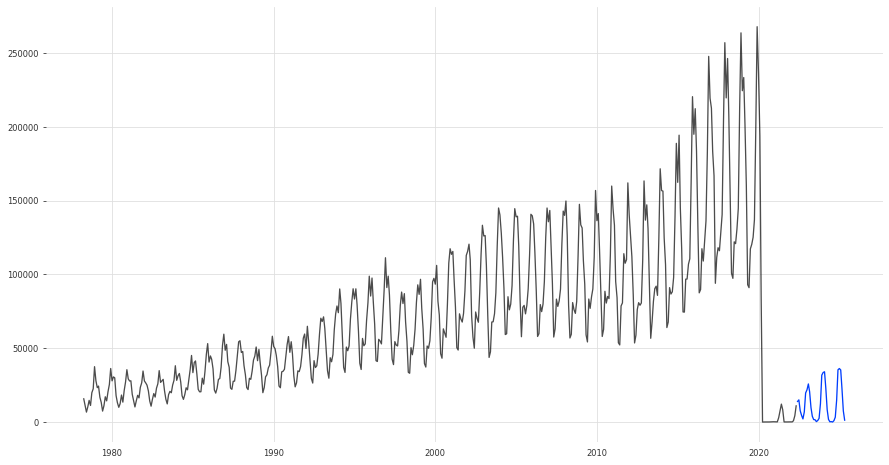

In [56]:
plt.figure(figsize=(15,8))

plt.plot(y, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_pred_df)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

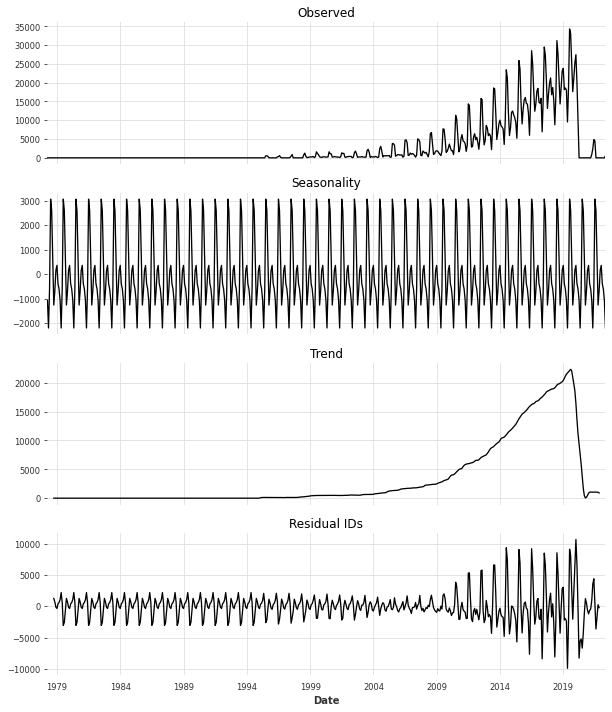

In [57]:
#TOTAL ALL TRAVEL PURPOSESAuckland ETS
y = arrivals['Holiday/VacationQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

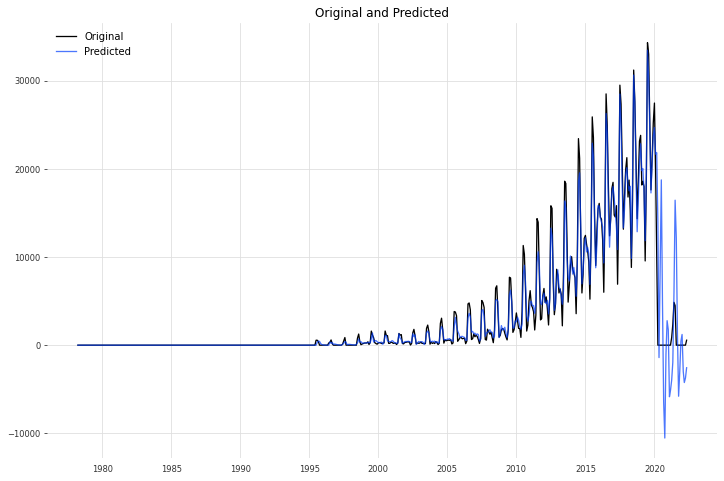

In [58]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [59]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationQueenstown   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4740.268
Date:                        Thu, 28 Jul 2022   AIC                           9518.535
Time:                                00:31:09   BIC                           9599.720
Sample:                            04-01-1978   HQIC                          9550.312
                                 - 05-01-2022   Scale                      3436365.816
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5929      0.044     13.409      0.000       0.506       0.680
smoothing_trend      5.929e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.4071      0.039     10.545      0.000       0.331       0.483
damping_trend           0.8664        nan        nan        nan         nan         nan
initial_level        1.621e-07   1603.814   1.01e-10      1.000   -3143.418    3143.418
initial_trend        5.418e-08    813.070   6.66e-11      1.000   -1593.587    1593.587
initial_seasonal.0  -2.194e-06   1157.737   -1.9e-09      1.000   -2269.122    2269.122
initial_seasonal.1   -1.27e-06   1155.045   -1.1e-09      1.000   -2263.847    2263.847
initial_seasonal.2     1.6e-06   1152.562   1.39e-09      1.000   -2258.980    2258.980
initial_seasonal.3   7.747e-07   1150.130   6.74e-10      1.000   -2254.212    2254.212
initial_seasonal.4  -2.707e-06   1147.446  -2.36e-09      1.000   -2248.954    2248.954
initial_seasonal.5  -5.419e-06   1144.431  -4.73e-09      1.000   -2243.044    2243.044
initial_seasonal.6   2.061e-06   1141.440   1.81e-09      1.000   -2237.182    2237.182
initial_seasonal.7   9.799e-06   1139.147    8.6e-09      1.000   -2232.688    2232.688
initial_seasonal.8   1.199e-05   1138.222   1.05e-08      1.000   -2230.874    2230.874
initial_seasonal.9  -2.436e-06   1139.161  -2.14e-09      1.000   -2232.715    2232.715
initial_seasonal.10 -8.388e-06   1142.464  -7.34e-09      1.000   -2239.188    2239.188
initial_seasonal.11          0   1148.984          0      1.000   -2251.967    2251.967
===================================================================================
Ljung-Box (Q):                      375.54   Jarque-Bera (JB):             31912.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           24305.61   Skew:                            -3.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+17. Standard errors may be unstable.
"""

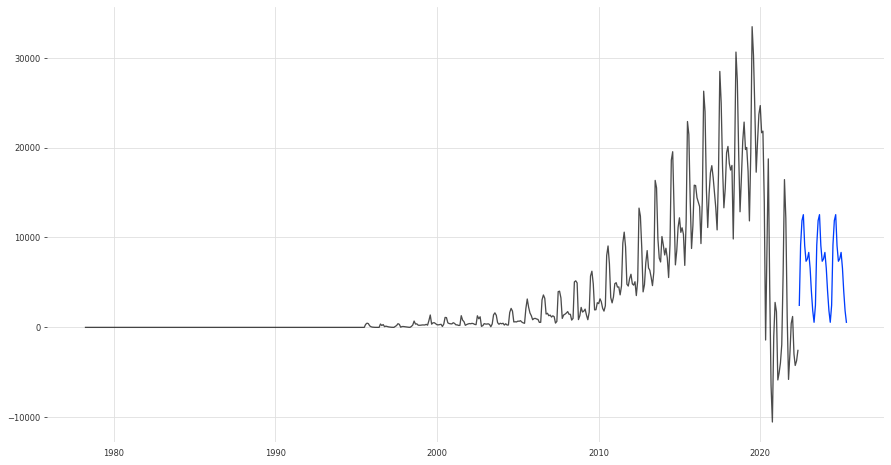

In [60]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

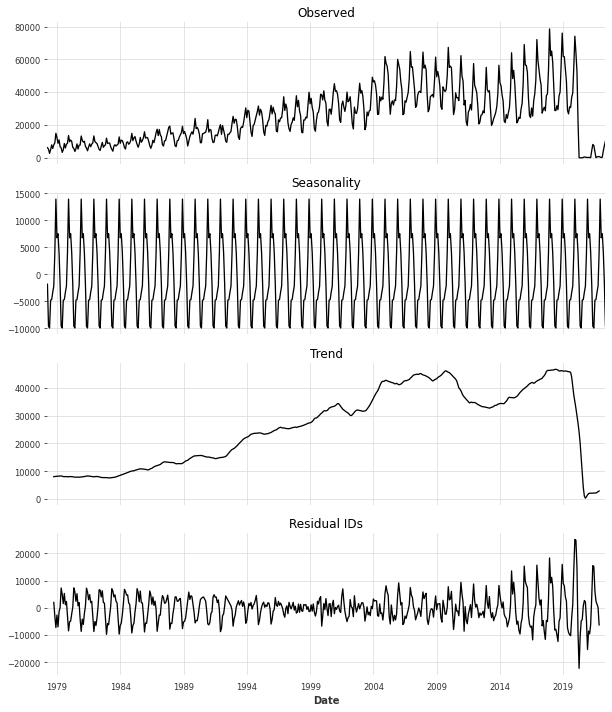

In [61]:
#TOTAL ALL TRAVEL PURPOSESChristchurch arima
y = arrivals['TOTAL ALL TRAVEL PURPOSESChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

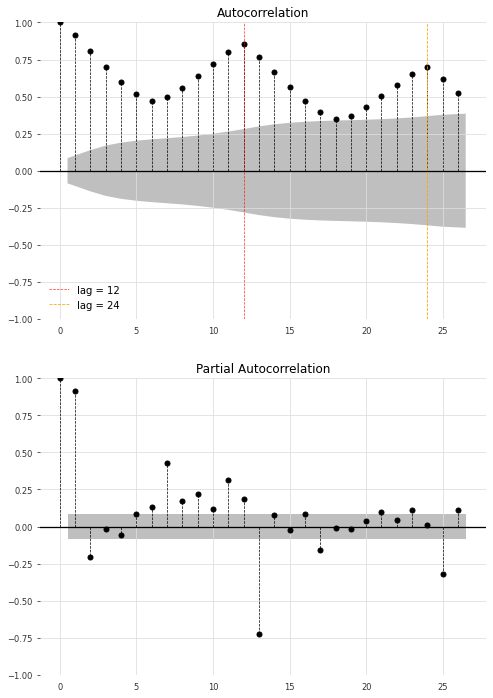

In [62]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [63]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  530
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -5080.254
Date:                              Thu, 28 Jul 2022   AIC                          10172.507
Time:                                      00:32:23   BIC                          10198.133
Sample:                                           0   HQIC                         10182.539
                                              - 530                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0737      0.020      3.766      0.000       0.035       0.112
ma.L2         -0.0909      0.027     -3.429      0.001      -0.143      -0.039
ar.S.L12       1.1279      0.092     12.316      0.000       0.948       1.307
ar.S.L24      -0.1611      0.078     -2.065      0.039      -0.314      -0.008
ma.S.L12      -0.6581      0.093     -7.060      0.000      -0.841      -0.475
sigma2      1.251e+07   4.97e-09   2.52e+15      0.000    1.25e+07    1.25e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1361.23
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              11.17   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.97e+31. Standard errors may be unstable.
"""

In [64]:
model = sarimax.SARIMAX(y, order=(0,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESChristchurch   No. Observations:                  530
Model:                  SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -5083.018
Date:                                   Thu, 28 Jul 2022   AIC                          10174.036
Time:                                           00:32:24   BIC                          10191.120
Sample:                                       04-01-1978   HQIC                         10180.723
                                            - 05-01-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.1211      0.091     12.320      0.000       0.943       1.299
ar.S.L24      -0.1553      0.078     -1.995      0.046      -0.308      -0.003
ma.S.L12      -0.6525      0.092     -7.104      0.000      -0.832      -0.472
sigma2      1.319e+07   4.04e-09   3.27e+15      0.000    1.32e+07    1.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):              1692.43
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              11.95   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+31. Standard errors may be unstable.
"""

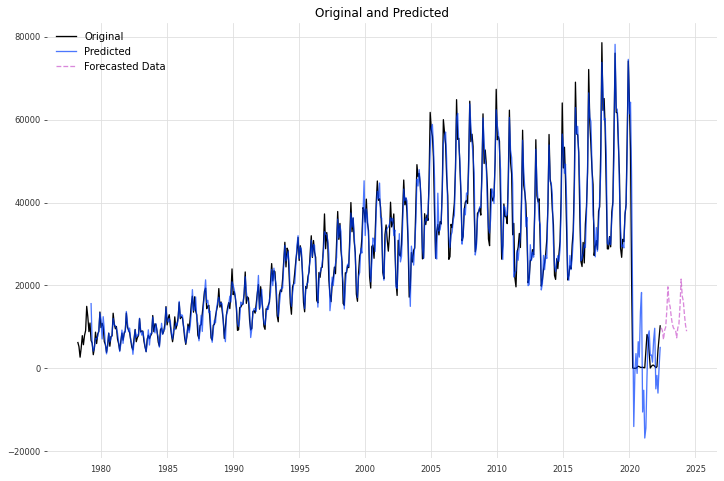

In [65]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

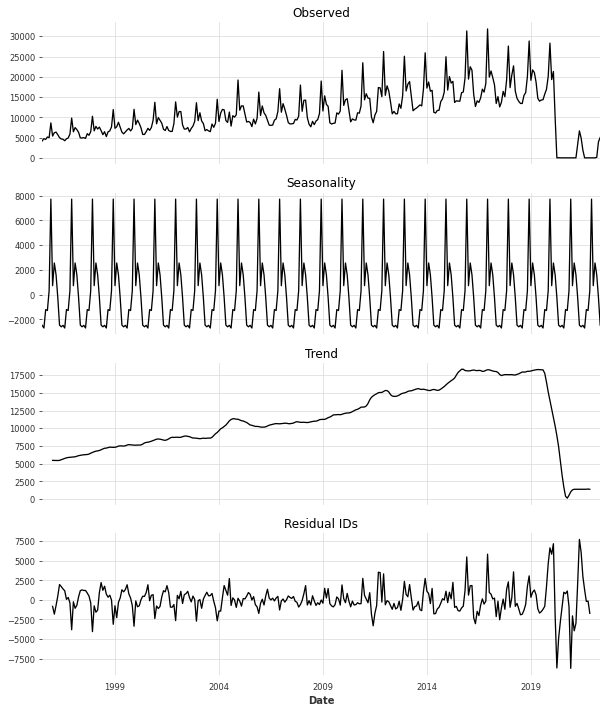

In [66]:
#TOTAL ALL TRAVEL PURPOSESWellington ETS
y = arrivals['TOTAL ALL TRAVEL PURPOSESWellington'].loc['1995-07':]

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

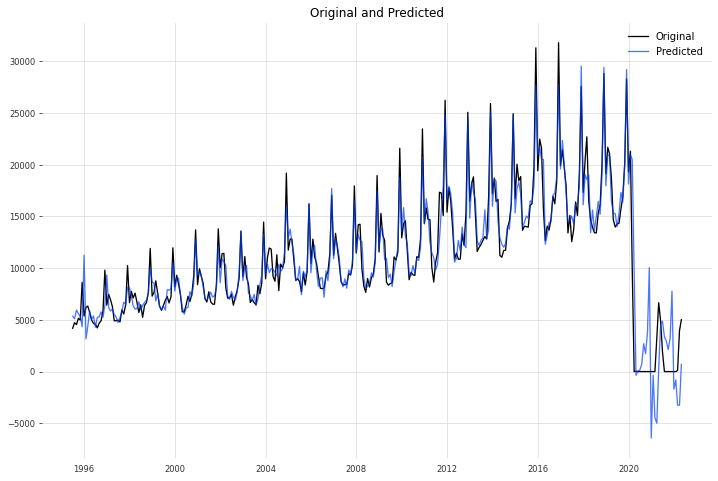

In [67]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [68]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          ETS Results                                          
===============================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESWellington   No. Observations:                  323
Model:                                       ETS(AAdA)   Log Likelihood               -2901.944
Date:                                 Thu, 28 Jul 2022   AIC                           5841.887
Time:                                         00:32:25   BIC                           5913.663
Sample:                                     07-01-1995   HQIC                          5870.539
                                          - 05-01-2022   Scale                      3725882.171
Covariance Type:                                approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6671        nan        nan        nan         nan         nan
smoothing_trend      6.671e-05      0.002      0.036      0.971      -0.004       0.004
smoothing_seasonal      0.3328        nan        nan        nan         nan         nan
damping_trend           0.8258        nan        nan        nan         nan         nan
initial_level        5319.2194   1851.831      2.872      0.004    1689.698    8948.741
initial_trend          50.8843   1172.968      0.043      0.965   -2248.091    2349.859
initial_seasonal.0    231.3437   1078.254      0.215      0.830   -1881.994    2344.682
initial_seasonal.1   -143.5937    997.574     -0.144      0.886   -2098.803    1811.616
initial_seasonal.2    594.7604    898.825      0.662      0.508   -1166.904    2356.425
initial_seasonal.3    418.5104   1005.380      0.416      0.677   -1551.998    2389.019
initial_seasonal.4   1239.3021   1044.727      1.186      0.236    -808.326    3286.930
initial_seasonal.5   5415.5520        nan        nan        nan         nan         nan
initial_seasonal.6   1371.2501    364.719      3.760      0.000     656.413    2086.087
initial_seasonal.7   2161.6146   1032.435      2.094      0.036     138.079    4185.150
initial_seasonal.8   2135.6562   1042.515      2.049      0.041      92.364    4178.949
initial_seasonal.9   1569.1562    999.604      1.570      0.116    -390.032    3528.344
initial_seasonal.10   494.3542    978.113      0.505      0.613   -1422.712    2411.421
initial_seasonal.11          0   1004.803          0      1.000   -1969.377    1969.377
===================================================================================
Ljung-Box (Q):                       56.28   Jarque-Bera (JB):              1032.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.24   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.88e+16. Standard errors may be unstable.
"""

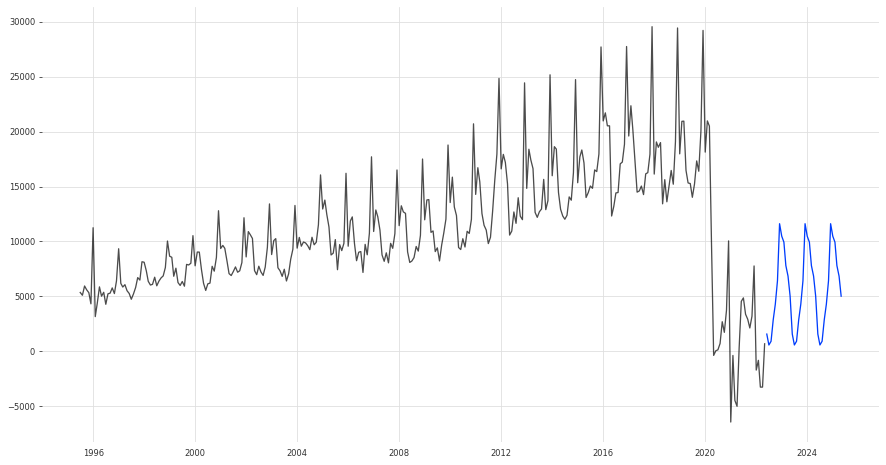

In [69]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

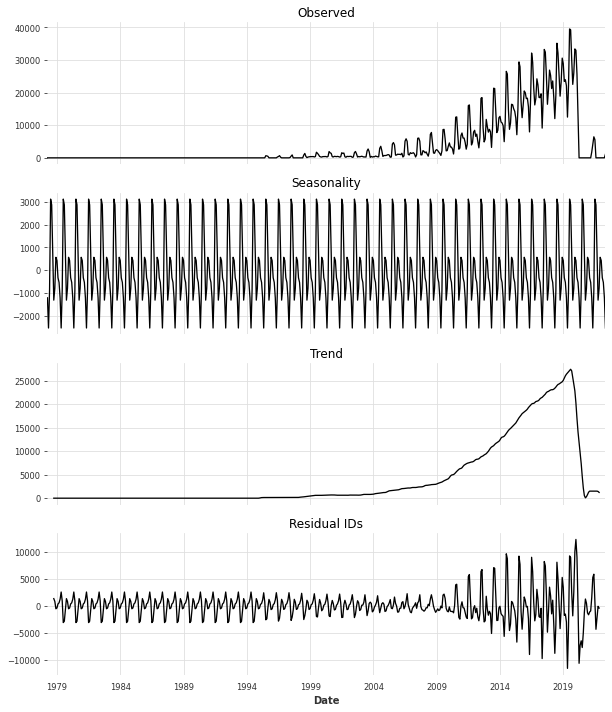

In [70]:
#TOTAL ALL TRAVEL PURPOSESQueenstown auto_arima
y = arrivals['TOTAL ALL TRAVEL PURPOSESQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

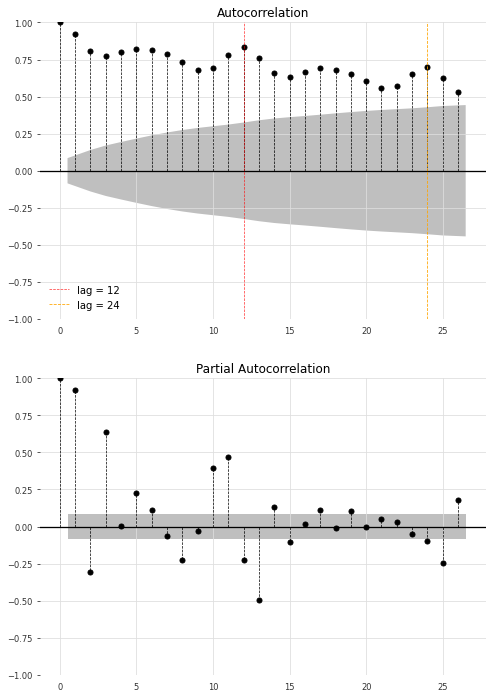

In [71]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [72]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12, method = 'cg', information_criterion = 'bic', error_action = 'ignore').summary()

C:\Users\lutim\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,2)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\lutim\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\lutim\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\lutim\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\lutim\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 728, in fit
    res = func(mlefit.params, t

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  530
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -4726.311
Date:                              Thu, 28 Jul 2022   AIC                           9462.621
Time:                                      00:39:22   BIC                           9483.976
Sample:                                           0   HQIC                          9470.981
                                              - 530                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4087      0.027     15.127      0.000       0.356       0.462
ar.L2         -0.6443      0.039    -16.668      0.000      -0.720      -0.569
ar.S.L12       0.9159      0.023     39.157      0.000       0.870       0.962
ma.S.L12      -0.4167      0.055     -7.558      0.000      -0.525      -0.309
sigma2      5.331e+06   2.45e+05     21.796      0.000    4.85e+06    5.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.16   Jarque-Bera (JB):             26874.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
model = sarimax.SARIMAX(y, order=(2,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESQueenstown   No. Observations:                  530
Model:                SARIMAX(2, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -4648.849
Date:                                 Thu, 28 Jul 2022   AIC                           9313.698
Time:                                         00:39:25   BIC                           9347.866
Sample:                                     04-01-1978   HQIC                          9327.073
                                          - 05-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2600      0.042      6.226      0.000       0.178       0.342
ar.L2         -0.4389      0.050     -8.699      0.000      -0.538      -0.340
ma.L1          0.0713      0.045      1.573      0.116      -0.018       0.160
ma.L2          0.0640      0.064      1.000      0.317      -0.061       0.190
ar.S.L12       0.1661      0.065      2.572      0.010       0.040       0.293
ar.S.L24       0.5569      0.047     11.968      0.000       0.466       0.648
ma.S.L12       0.3130      0.078      4.020      0.000       0.160       0.466
sigma2      2.458e+06   5.74e+04     42.854      0.000    2.35e+06    2.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8760.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

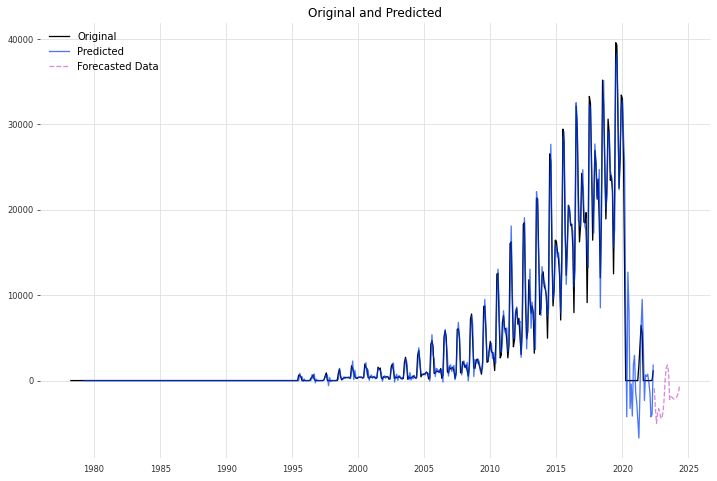

In [74]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

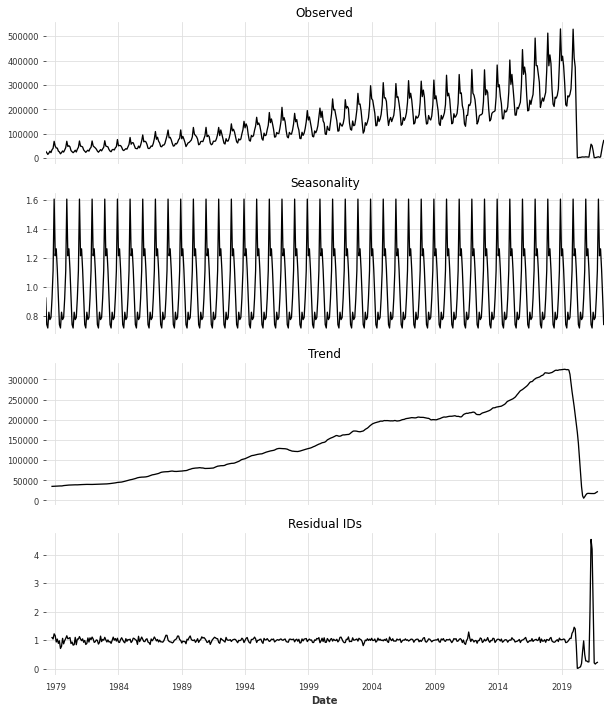

In [75]:
#TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
y = arrivals['TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

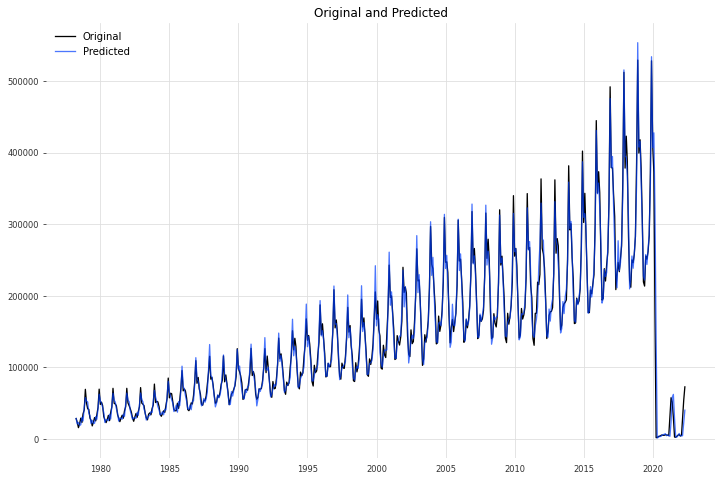

In [76]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [77]:
exp_fit.summary()

Dep. Variable:,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS,No. Observations:,530
Model:,ExponentialSmoothing,SSE,99266246002.963
Optimized:,True,AIC,10129.543
Trend:,Multiplicative,BIC,10202.182
Seasonal:,Multiplicative,AICC,10131.033
Seasonal Periods:,12,Date:,"Thu, 28 Jul 2022"
Box-Cox:,False,Time:,00:39:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,1.3389e-34,beta,True


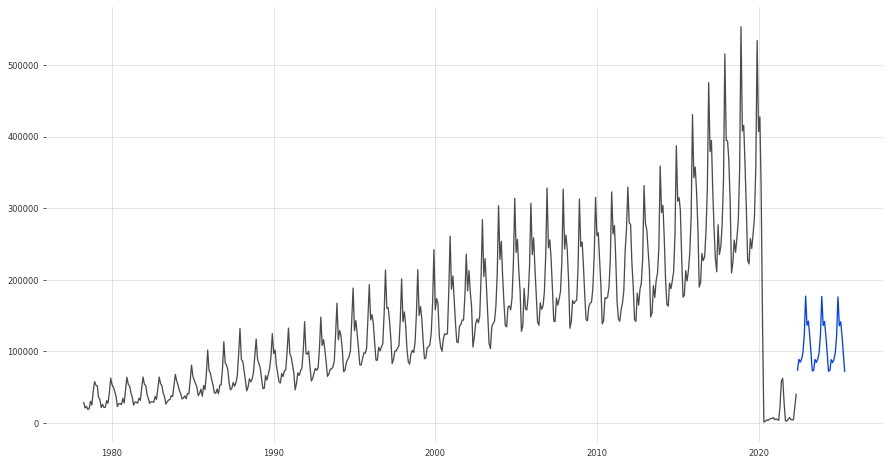

In [78]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

# 2.0 Accomodation-Data